# <span style="color:teal">Plant </span><span style="color:green">*Seedlings*</span><span style="color:teal"> Classification</span>
***



#### Initialization

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


#### Load Data

In [2]:
train_dir = '../input/plant-seedlings-classification/train'
test_dir = '../input/plant-seedlings-classification/test'
sample_submission = pd.read_csv('../input/plant-seedlings-classification/sample_submission.csv')


#### Different Species

In [3]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))
    

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


#### Training Data Files

In [4]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['../input/plant-seedlings-classification/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)


Training Data:  (4750, 3)


#### Image Pre-processing

In [5]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp


#### Loading Traing Data

In [6]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)


CPU times: user 53.2 s, sys: 3.56 s, total: 56.8 s
Wall time: 1min 20s


#### Sample Images

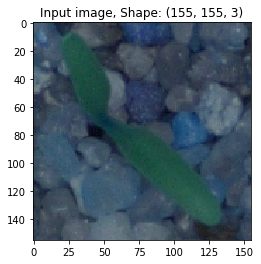

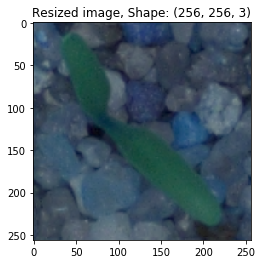

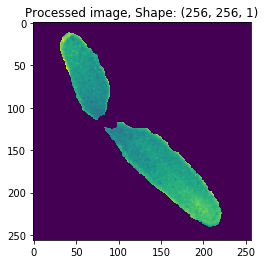

In [7]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()


#### One-hot Encoding

In [8]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))


#### CV-Partition

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)


#### Input Shape

In [10]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)


Input Shape is : (256, 256, 4)


## <span style="color:teal">Architecture</span>
---

In [14]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Flatten, Dense

In [16]:
model = Sequential()

input_shape = (256, 256, 4)

model.add(Conv2D(filters=64, kernel_size=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))

model.add(Dense(12, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 64)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)       0         
__________

#### Compile the model

In [17]:
model.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])


#### Set a learning rate annealer

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)


#### Data Augumentation

In [19]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)


In [20]:
batch_size = 32
epochs = 40


#### Load the Saved Weights *(pre-trained) *

In [21]:
model.load_weights('../input/cnn-model/cnn_model.h5')


### <span style="color:teal">Fit the model</span>

In [ ]:
# Training
#history = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                                  #validation_data = (x_val,y_val), verbose = 1, 
                                  #steps_per_epoch=x_train.shape[0] // batch_size, 
                                  #callbacks=[learning_rate_reduction])

### <span style="color:teal">Predictions</span>
***

In [22]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['../input/plant-seedlings-classification/test/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)


                                                file
0  ../input/plant-seedlings-classification/test/a...
1  ../input/plant-seedlings-classification/test/c...
2  ../input/plant-seedlings-classification/test/d...
3  ../input/plant-seedlings-classification/test/b...
4  ../input/plant-seedlings-classification/test/6...
CPU times: user 5.28 s, sys: 492 ms, total: 5.77 s
Wall time: 7.98 s


#### Sample Test images

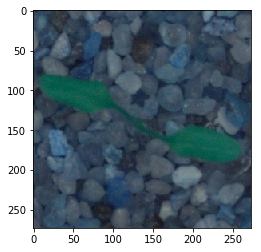

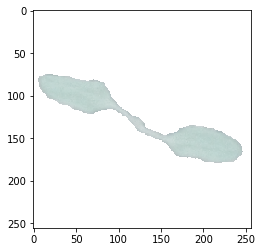

In [23]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()


#### Prediction Score [Validation Set]

In [24]:
score = model.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

475/475 [==============================] - 7s 14ms/step
Accuracy on Validation Set 0.9515789486232556


#### Prediction on Test Set

In [26]:
Pred_labels = np.argmax(model.predict(x_test),axis = 1)


#### Submit Test results (Deep Neural Network with _New Model_)

In [27]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('submission.csv', index=False)
print(submission.head())


            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


***
## <span style="color:teal">Applying Suppot Vector Machine</span>
***

#### Extracting Features from last Layer

In [29]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)


(4275, 100)
(475, 100)
(794, 100)


#### Applying SVM

In [30]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


#### Prediction Score [Training Features]

In [31]:
svm.score(feat_train,np.argmax(y_train,axis=1))


0.9988304093567252

#### Prediction Score [Validation Features]

In [32]:
svm.score(feat_val,np.argmax(y_val,axis=1))


0.6147368421052631

#### Predict on [Test Features]

In [33]:
Pred_labels = svm.predict(feat_test)


#### Submission for Competition

In [34]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_svm_linear.csv', index=False)

            file           species
0  0021e90e4.png  Loose Silky-bent
1  003d61042.png           Fat Hen
2  007b3da8b.png  Loose Silky-bent
3  0086a6340.png  Common Chickweed
4  00c47e980.png        Sugar beet
